## 1. Data Preparation

### 1.1 Import libraries

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
from pandas import json_normalize
from scipy.stats import kurtosis, skew
import os
import json
pd.set_option('display.max_columns', 100)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import lightgbm as lgb
from skopt import dummy_minimize

import warnings
warnings.filterwarnings('ignore')

### 1.2 Loading the dataset

In [2]:
def load_df(csv_path, skiprows=None, nrows=None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     #converters are dict of functions for converting values in certain columns. Keys can either be integers or column labels.
                     #json.loads() method can be used to parse a valid JSON string and convert it into a Python Dictionary.
                     #It is mainly used for deserializing native string, byte, or byte array which consists of JSON data into Python Dictionary.
                     converters={col: json.loads for col in json_cols}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for col in json_cols:
        column_as_df = json_normalize(df[col])
        column_as_df.columns = [f"{col}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(col, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [3]:
csv_train_path = 'train_v2.csv'
csv_test_path = 'test_v2.csv'

In [4]:
%%time
df_test = load_df(csv_test_path)
df_train = pd.read_csv('df_train_2018.csv')

id_test = df_test['fullVisitorId']
del df_test['fullVisitorId'], df_test['totals.transactionRevenue']

df_train.shape, df_test.shape

CPU times: total: 1min 21s
Wall time: 1min 48s


((164709, 33), (401589, 57))

## 2. Data Analysis/Cleaning

### 2.1 Constant Variables

In [5]:
c = 0
train_const, test_const = [],[]
print('==== df_train =====')
for col in df_train.copy():
    if df_train[col].nunique() == 1:
        train_const.append(col)
        c += 1      
print(f'Detect {c} variables.')
c = 0
print('==== df_test ======')
for col in df_test.copy():
    if df_test[col].nunique() == 1:
        test_const.append(col)
        c += 1       
print(f'Detect {c} variables.')

==== df_train =====
Detect 1 variables.
==== df_test ======
Detect 23 variables.


In [6]:
df_train.drop(train_const, axis=1, inplace=True)
df_test.drop(test_const, axis=1, inplace=True)

### 2.2 Missing Data

In [ ]:
# Impute data on Train
for col in ['trafficSource.adwordsClickInfo.gclId',
            'trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.page',
            'trafficSource.adwordsClickInfo.slot']:
    df_train[col].fillna('unknown', inplace=True)

df_train['totals.transactionRevenue'].fillna(0, inplace=True)
df_train['totals.pageviews'].fillna(1, inplace=True)
df_train['totals.sessionQualityDim'].fillna(df_train['totals.sessionQualityDim'].mode()[0], inplace=True)
df_train['trafficSource.keyword'].fillna('(not set)', inplace=True)
df_train['trafficSource.referralPath'].fillna('(not set)', inplace=True)
df_train['trafficSource.adContent'].fillna('(not set)', inplace=True)
df_train.drop(['totals.timeOnSite', 'totals.totalTransactionRevenue','totals.transactions'], axis=1, inplace=True)

In [8]:
# Impute data on Test
for col in ['trafficSource.referralPath', 'trafficSource.adwordsClickInfo.gclId',
            'trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.page',
            'trafficSource.adwordsClickInfo.slot', 'trafficSource.adContent']:
    df_test[col].fillna('unknown', inplace=True)

df_test['totals.pageviews'].fillna(1, inplace=True)
df_test['trafficSource.keyword'].fillna('(not set)', inplace=True)
df_test['trafficSource.referralPath'].fillna('"(not set)"', inplace=True)
df_test['trafficSource.adContent'].fillna('"(not set)"', inplace=True)
df_test.drop(['totals.timeOnSite','totals.totalTransactionRevenue','totals.transactions'], axis=1, inplace=True)

### 2.3 Target Variable

In [11]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].astype('float')
df_train["totals.transactionRevenue"] = np.log1p(df_train["totals.transactionRevenue"])
print(f'Skewness after log transform: {skew((df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))}')

Skewness of normal distribution (should be 0): 0.2027167318961024


- **Skewness** seems symmetrical.

## 3. Feature Engineering

### 3.1 Removing some variables 

In [13]:
df_train.drop(['fullVisitorId', 'date2', '_hour'], axis=1, inplace=True)
df_test.drop(['date', 'visitId', 'visitStartTime', 'date2'], axis=1, inplace=True)

### 3.2 Changing data types

In [16]:
int_cols = ['visitNumber', 'totals.hits','totals.pageviews','totals.sessionQualityDim']

for col in int_cols:
    df_test[col] = df_test[col].astype('int64')

### 3.3 Log Transformation

In [20]:
print('Train: ')
for col in [x for x in df_train.select_dtypes(include=['float', 'int']) if (x != 'totals.transactionRevenue')]:
    print(f'Skew {col}: {skew(df_train[col])}')
print()
print('Test: ')
for col in df_test.select_dtypes(include=['float', 'int']):
    print(f'Skew {col}: {skew(df_test[col])}')

Train: 
Skew visitNumber: 3.585578780803558
Skew totals.hits: 1.3275912482231458
Skew totals.pageviews: 1.3205392429525427
Skew totals.sessionQualityDim: 3.0658113898708317

Test: 
Skew visitNumber: 3.362601510353562
Skew totals.hits: 1.1526050188091876
Skew totals.pageviews: 1.1584673197471451
Skew totals.sessionQualityDim: 2.5804308835986927


In [19]:
for df in [df_train, df_test]:
    df['visitNumber'] = np.log1p(df['visitNumber'])
    df['totals.hits'] = np.log1p(df['totals.hits'])
    df['totals.pageviews'] = np.log1p(df['totals.pageviews'])
    df['totals.sessionQualityDim'] = np.log1p(df['totals.sessionQualityDim'])

### 3.4 Label Encoder

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
print('Columns that are converted to numerical values with label encodedr:')
for col in df_train.columns:
    if df_train[col].dtype == 'O':
        print(col)
        #print(col, train[col].unique())
        df_train.loc[:, col] = le.fit_transform(df_train.loc[:, col])
        df_test.loc[:, col] = le.fit_transform(df_test.loc[:, col])

Columns that are converted to numerical values with label encodedr:
channelGrouping
customDimensions
hits
device.browser
device.operatingSystem
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
trafficSource.campaign
trafficSource.source
trafficSource.medium
trafficSource.keyword
trafficSource.referralPath
trafficSource.adContent
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.adNetworkType


## 4. Model Training

### 4.1 Split Data

In [22]:
X = df_train.drop('totals.transactionRevenue', axis=1)
y = df_train['totals.transactionRevenue']

### 4.2 Cross Validation with LGBMRegressor

In [45]:
num_folds = 5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

fold = 0
accs_tr, accs_val = [], []

for train_idx, valid_idx in folds.split(X, y):
    train_x = X.iloc[train_idx]
    train_y = y.iloc[train_idx]
    
    valid_x = X.iloc[valid_idx]
    valid_y = y.iloc[valid_idx]
    
    # Fit Model on Train
    
    reg = lgb.LGBMRegressor(n_estimators=3000)
    reg.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric="rmse", early_stopping_rounds = 3000, verbose = 0)
    
    
    # Train Acc    
    y_pred_tr = reg.predict(train_x)
    result = np.sqrt(mean_squared_error(train_y, y_pred_tr))
    accs_tr.append(result)
    
    # Valid Acc
    y_pred_val = reg.predict(valid_x)
    result_val = np.sqrt(mean_squared_error(valid_y, y_pred_val))
    accs_val.append(result_val)

    
    print(f'fold {fold}')
    fold += 1

print(np.mean(accs_tr))
print(np.mean(accs_val))

fold 0
fold 1
fold 2
fold 3
fold 4
0.2126352966187431
0.23055686562772473


### 4.3 Hyperparameter tuning (Random search - skopt)

In [48]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    mdl = lgb.LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                            subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                            n_estimators=3000)
    mdl.fit(train_x, train_y)
    
    y_pred = reg.predict(valid_x)
    
    return np.sqrt(mean_squared_error(valid_y, y_pred))

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

resultado = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 16.4810
Function value obtained: 0.2389
Current minimum: 0.2389
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 22.9250
Function value obtained: 0.2389
Current minimum: 0.2389
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 25.1310
Function value obtained: 0.2389
Current minimum: 0.2389
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895] 

Iteration No: 4 ended. Evaluation done at random point.
Time ta

In [49]:
resultado.x

[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176]

In [53]:
num_folds = 5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

fold = 0
accs_tr, accs_val = [], []

for train_idx, valid_idx in folds.split(X, y):
    train_x = X.iloc[train_idx]
    train_y = y.iloc[train_idx]
    
    valid_x = X.iloc[valid_idx]
    valid_y = y.iloc[valid_idx]
    
    # Fit Model on Train
    
    reg = lgb.LGBMRegressor(n_estimators=3000, learning_rate=0.098, num_leaves=74, min_child_samples=10, subsample=0.33, colsample_bytree=0.23)
    reg.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric="rmse", early_stopping_rounds = 3000, verbose = 0)
    
    
    # Train Acc    
    y_pred_tr = reg.predict(train_x)
    result = np.sqrt(mean_squared_error(train_y, y_pred_tr))
    accs_tr.append(result)
    
    # Valid Acc
    y_pred_val = reg.predict(valid_x)
    result_val = np.sqrt(mean_squared_error(valid_y, y_pred_val))
    accs_val.append(result_val)

    
    print(f'fold {fold}')
    fold += 1

print(np.mean(accs_tr))
print(np.mean(accs_val))

fold 0
fold 1
fold 2
fold 3
fold 4
0.2012509474188227
0.2336032941987102


### 4.4 Feature Importance (Plot)

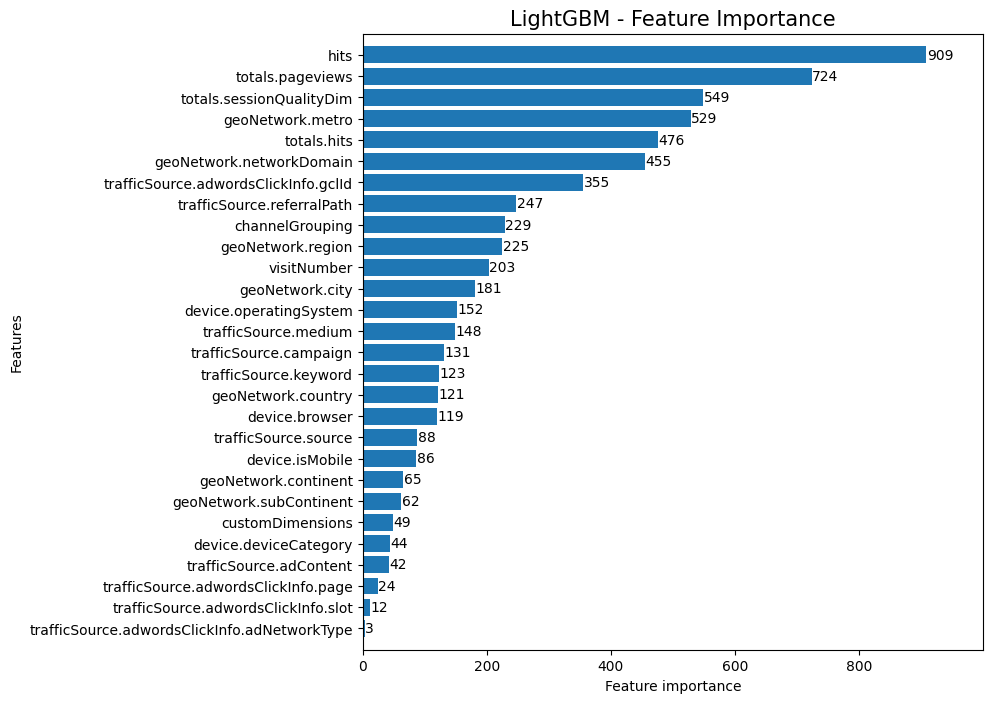

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
lgb.plot_importance(reg, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
#plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

## 5. Inference and Submission

### 5.1 Inference on test data

In [55]:
y_pred = reg.predict(df_test)

### 5.2 Submission

In [56]:
sub_df = pd.DataFrame({"fullVisitorId":id_test})
y_pred[y_pred<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(y_pred)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("submission.csv", index=False)

## 6. References

[1] https://www.kaggle.com/code/kostoglot/winning-solution <br>
[2] https://www.kaggle.com/code/oceands/basics-of-google-analytics <br>
[3] https://www.youtube.com/watch?v=WhnkeasZNHI